# 01 – Exploração do Snapshot

Primeiro notebook do **creditlab**.

Nele, vamos:
1. Instanciar o `CreditDataSynthesizer`.
2. Gerar a *safra 0* (snapshot) para alguns grupos homogêneos.
3. Fazer uma exploração inicial: contagem de contratos por grupo, estatísticas descritivas e um histograma de dias em atraso.

⚠️ Este notebook assume que o módulo `credit_data_synthesizer.py` está no mesmo diretório ou em `PYTHONPATH`.

In [2]:
import sys
from pathlib import Path

# Adiciona o diretório-pai ao sys.path
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import matplotlib.pyplot as plt


from importlib import reload
import credit_data_synthesizer as cds
reload(cds)  # garante versão atual no notebook

from credit_data_synthesizer import (
    CreditDataSynthesizer,
    default_group_profiles,   # função helper já incluída no módulo
)

from credit_data_sampler import (
    TargetSampler
)

pd.set_option('display.max_rows', 500)

## Parâmetros iniciais

In [3]:
# from credit_data_synthesizer import CreditDataSynthesizer, default_group_profiles
# from credit_data_sampler import TargetSampler

# # gerar painel com churn dinamico
# synth = CreditDataSynthesizer(
#     group_profiles=default_group_profiles(2),
#     contracts_per_group=1_000,
#     n_safras=12,
#     new_contract_rate=0.05,
#     closure_rate=0.03,
# )
# _, panel, _ = synth.generate()

# # rebalancear bad-rate preservando ranking dos grupos
# sampler = TargetSampler(target_ratio=0.08, preserve_rank=True)
# panel_bal = sampler.fit_transform(panel, target_col="ever90m12", safra_col="safra")
# display(panel_bal.head())

In [4]:
#panel_bal.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [6]:
# ----- parâmetros que você quer -----
YEARS=4
n_groups = 6
contracts_per_group = 500
n_safras = 12*YEARS
seed = 0

# 1) Obtenha os perfis padrão e pegue só os três primeiros
group_profiles = default_group_profiles(n_groups)

# 2) Instancie o sintetizador
synth = CreditDataSynthesizer(
    group_profiles=group_profiles,
    contracts_per_group=contracts_per_group,
    n_safras=n_safras,
    random_seed=0,
    start_safra = 201501,
    target_ratio=0.10,
    new_contract_rate=0.045,
    closure_rate=0.025,
    force_event_rate=True,
    verbose=True
)

## Geração da safra 0

In [7]:
# 3) Gere os dados
df_snapshot, df_panel, df_trace = synth.generate()

print(f"Snapshot gerado com {len(df_snapshot):,} linhas")
print(f"Painel gerado com {len(df_panel):,} linhas")
print(f"Rastro gerado com {len(df_trace):,} linhas")
display(df_snapshot.head())

Snapshot gerado com 3,000 linhas
Painel gerado com 178,436 linhas
Rastro gerado com 12,367 linhas


,id_contrato,grupo_homogeneo,data_inicio_contrato,data_ref,safra,dias_atraso,nivel_refinanciamento,renda_mensal,tempo_no_endereco_anual,tempo_no_emprego_anual,...,ever360m18,flag_cura,write_off,id_cliente,data_nascimento,sexo,duration_m,age_months,data_fim_contrato,subcluster
0,10000000,GH1,2014-09-06,2015-01-01,201501,15,0,5457.395508,6.322387,16.075324,...,0,0,0,405.0,1968-12-21,F,25.0,0.0,NaT,14.0
1,10000001,GH1,2014-09-14,2015-01-01,201501,120,0,3679.122559,1.884695,12.680055,...,0,0,0,980.0,1958-12-08,M,28.0,0.0,NaT,6.0
2,10000002,GH1,2014-09-07,2015-01-01,201501,60,0,4921.681152,4.197271,8.175679,...,0,0,0,348.0,1970-11-21,M,60.0,0.0,NaT,9.0
3,10000003,GH1,2014-07-05,2015-01-01,201501,15,0,3406.271973,1.687924,1.471017,...,0,0,0,569.0,1990-12-13,F,28.0,0.0,NaT,4.0
4,10000004,GH1,2014-11-17,2015-01-01,201501,15,0,6203.081543,0.076248,5.806983,...,0,0,0,793.0,1955-08-16,F,66.0,0.0,NaT,14.0


In [ ]:
df_panel.groupby(['safra','grupo_homogeneo'])['ever90m12'].mean()*100

In [11]:
df_panel.groupby('grupo_homogeneo')['ever90m12'].mean()*100

grupo_homogeneo
GH1    69.686660
GH2    69.006636
GH3    65.399890
GH4    63.252084
GH5    59.028128
GH6    54.572120
Name: ever90m12, dtype: float64

In [ ]:
df_panel['nivel_refinanciamento'].describe()

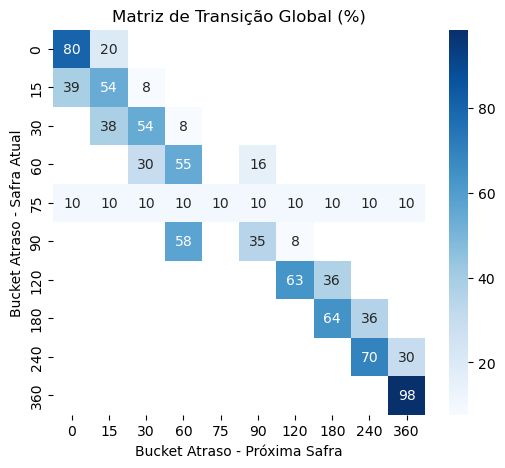

In [31]:
import numpy as np
import importlib
import transition_matrix_estimator

importlib.reload(transition_matrix_estimator)

from transition_matrix_estimator import TransitionMatrixLearner

global_learner = TransitionMatrixLearner(buckets=[0,15,30,60,75,90,120,180,240,360])
global_learner.fit(
    df_panel,
    id_col="id_contrato",
    time_col="data_ref",
    bucket_col="dias_atraso",
    #group_col='grupo_homogeneo',
)

#print("Global matrix:\n", global_learner.get_matrix())
global_learner.plot_heatmaps(modes=["global"]); #save_dir="figs/")

In [ ]:
# balanceando target
sampler = TargetSampler(target_ratio=0.10)
balanced = sampler.fit_transform(df_panel, target_col="ever90m12")

#prev = balanced.groupby("safra")["ever90m12"].mean()*100
#print("Prev per safra (balanced):")
#print(prev.head())

In [ ]:
df_snapshot.groupby('sexo')['ever90m12'].mean()*100

In [ ]:
df_snapshot.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
balanced.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
len(balanced), len(df_panel)

In [ ]:
balanced['safra'].value_counts()

In [ ]:
balanced.groupby(by='safra', as_index=True)['ever90m12'].mean()*100

### Contagem de contratos por `grupo_homogeneo`

In [ ]:
df_snapshot['grupo_homogeneo'].value_counts()

### Estatísticas descritivas das variáveis numéricas

In [ ]:
cols_numericas = balanced.select_dtypes(include='number').columns.drop(['id_contrato', 'id_cliente'])

agg_df = (
    balanced[cols_numericas.tolist() + ['grupo_homogeneo']]
    .groupby('grupo_homogeneo')
    .agg(['min', 'mean', 'max'])
)

# Flatten columns
agg_df.columns = ['_'.join(col) for col in agg_df.columns]
agg_df.reset_index(inplace=True)

# Supondo que agg_df tenha a coluna 'grupo_homogeneo'
agg_df = agg_df.copy()
agg_df['grupo_idx'] = agg_df['grupo_homogeneo'].str.extract(r'GH(\d+)').astype(int)
agg_df = agg_df.sort_values('grupo_idx').drop(columns='grupo_idx')

agg_df.head(10)

### Distribuição de `dias_atraso`

In [ ]:
plt.figure()
balanced['dias_atraso'].hist(bins=30)
plt.xlabel('Dias em atraso')
plt.ylabel('Número de contratos')
plt.title('Histograma de dias em atraso – safra 0')
plt.show()

In [ ]:
df_snapshot.shape